<a href="https://colab.research.google.com/github/Adityakushwaha2006/Quidich-Hackenza-2025-CSIS/blob/main/Quidich_CSIS_iter1_AdityaKush.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SyntaxError: invalid syntax (<ipython-input-1-cf08b42c563e>, line 1)

In [ ]:
# Install MediaPipe with specific version and extra flags
!pip install --upgrade pip
!pip install --no-cache-dir mediapipe

# If that doesn't work, try with specific version
!pip install --no-cache-dir mediapipe==0.10.5

# Restart runtime (you'll need to do this manually after running this cell)
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 240.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 401.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━

Standard pose drawing failed: module 'mediapipe' has no attribute 'framework'
Camera 1


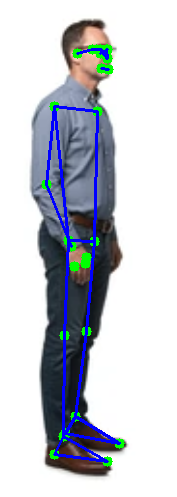

Standard pose drawing failed: module 'mediapipe' has no attribute 'framework'
Camera 2


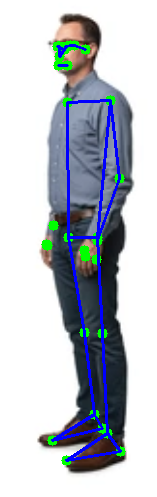

Standard pose drawing failed: module 'mediapipe' has no attribute 'framework'
Camera 3


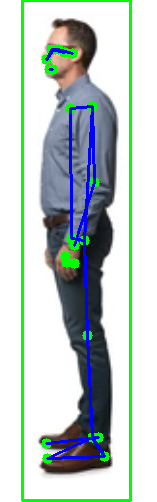

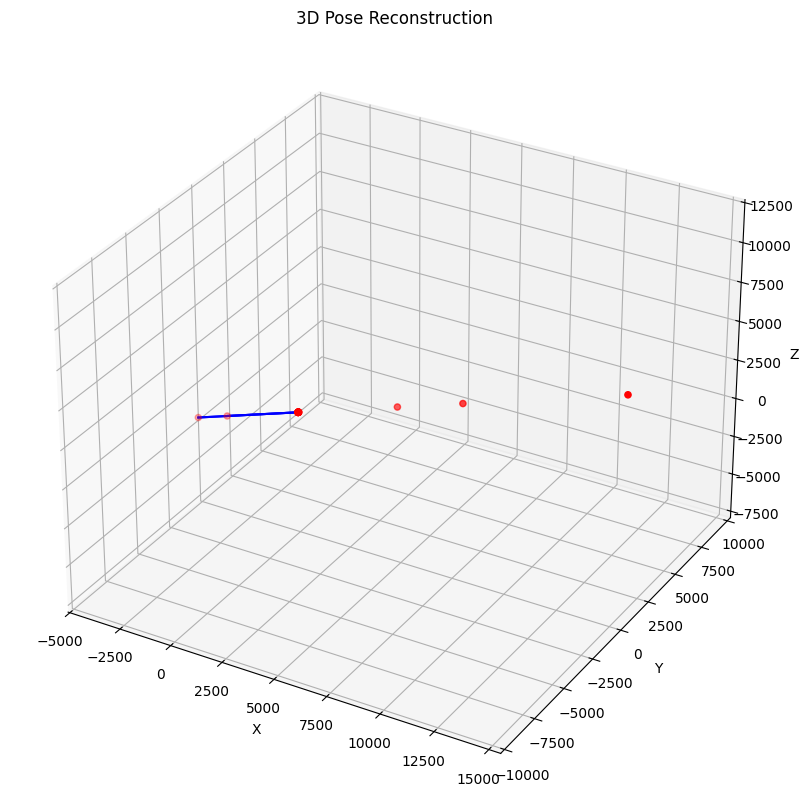

[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window


AttributeError: 'NoneType' object has no attribute 'point_size'

In [ ]:
# Install required packages
!pip install mediapipe
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install open3d
!pip install deep-sort-realtime

import cv2
import numpy as np
import mediapipe as mp
import open3d as o3d
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# For Google Colab display
try:
    from google.colab.patches import cv2_imshow
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# ======================= COMPONENT 1: IMAGE INPUT =======================
def load_images(image_paths):
    """
    Load multiple images from the provided paths

    Args:
        image_paths (list): List of image file paths

    Returns:
        list: List of loaded images
    """
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")
        images.append(img)

    return images

# ======================= COMPONENT 2: MEDIAPIPE POSE ESTIMATION =======================
class PoseEstimator:
    def __init__(self, min_detection_confidence=0.5, min_tracking_confidence=0.5):
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=min_tracking_confidence
        )
        self.mp_drawing = mp.solutions.drawing_utils

    def estimate_pose(self, image):
        """
        Estimate pose landmarks from an image

        Args:
            image (np.ndarray): Input image

        Returns:
            dict: Dictionary containing landmark positions
        """
        # Convert the image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image to get pose landmarks
        results = self.pose.process(image_rgb)

        if not results.pose_landmarks:
            return None

        # Extract landmarks
        landmarks = {}
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            landmarks[idx] = {
                'x': landmark.x,
                'y': landmark.y,
                'z': landmark.z,
                'visibility': landmark.visibility
            }

        return landmarks

    def draw_pose(self, image, landmarks):
        """
        Draw pose landmarks on an image - corrected for MediaPipe compatibility

        Args:
            image (np.ndarray): Input image
            landmarks: Pose landmarks

        Returns:
            np.ndarray: Image with pose landmarks drawn
        """
        if landmarks is None:
            return image

        # Create a copy of the image
        img_copy = image.copy()

        # Convert to RGB for drawing
        img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

        # Create a new pose landmarks object that MediaPipe can use
        # This avoids using internal _landmark_pb2 method
        pose_landmarks_proto = mp.framework.formats.landmark_pb2.NormalizedLandmarkList()

        for idx, landmark_data in landmarks.items():
            landmark = pose_landmarks_proto.landmark.add()
            landmark.x = landmark_data['x']
            landmark.y = landmark_data['y']
            landmark.z = landmark_data['z']
            landmark.visibility = landmark_data['visibility']

        # Draw the pose landmarks
        self.mp_drawing.draw_landmarks(
            img_rgb,
            pose_landmarks_proto,
            self.mp_pose.POSE_CONNECTIONS
        )

        # Convert back to BGR
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

        return img_bgr

    def draw_pose_simple(self, image, landmarks):
        """
        Alternative simpler method to draw pose landmarks
        Useful if the standard MediaPipe drawing still causes issues

        Args:
            image (np.ndarray): Input image
            landmarks: Pose landmarks

        Returns:
            np.ndarray: Image with pose landmarks drawn
        """
        if landmarks is None:
            return image

        img_copy = image.copy()
        h, w = img_copy.shape[:2]

        # Draw points
        for idx, landmark_data in landmarks.items():
            if landmark_data['visibility'] > 0.5:
                x, y = int(landmark_data['x'] * w), int(landmark_data['y'] * h)
                cv2.circle(img_copy, (x, y), 5, (0, 255, 0), -1)

        # Define connections similar to MediaPipe's POSE_CONNECTIONS
        connections = [
            # Torso
            (11, 12), (12, 24), (24, 23), (23, 11),
            # Right arm
            (12, 14), (14, 16),
            # Left arm
            (11, 13), (13, 15),
            # Right leg
            (24, 26), (26, 28), (28, 32), (32, 30), (30, 28),
            # Left leg
            (23, 25), (25, 27), (27, 31), (31, 29), (29, 27),
            # Face
            (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
            # Face connections
            (9, 10)
        ]

        # Draw lines
        for connection in connections:
            if (connection[0] in landmarks and connection[1] in landmarks and
                landmarks[connection[0]]['visibility'] > 0.5 and
                landmarks[connection[1]]['visibility'] > 0.5):

                x1 = int(landmarks[connection[0]]['x'] * w)
                y1 = int(landmarks[connection[0]]['y'] * h)
                x2 = int(landmarks[connection[1]]['x'] * w)
                y2 = int(landmarks[connection[1]]['y'] * h)

                cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)

        return img_copy

# ======================= COMPONENT 3: DEEPSORT PLAYER TRACKING =======================
class PlayerTracker:
    def __init__(self, max_age=30, n_init=3):
        self.tracker = DeepSort(
            max_age=max_age,
            n_init=n_init
        )

    def track_player(self, image, bbox):
        """
        Track a player in the image using DeepSort

        Args:
            image (np.ndarray): Input image
            bbox (tuple): Bounding box in format (x1, y1, x2, y2)

        Returns:
            tuple: (track_id, updated_bbox)
        """
        if bbox is None:
            return None

        x1, y1, x2, y2 = bbox
        w, h = x2 - x1, y2 - y1

        # DeepSort expects detections in format [bbox, confidence, class]
        detection = [
            [x1, y1, w, h],  # bbox in format (x, y, width, height)
            1.0,  # confidence
            0     # class
        ]

        # Update the tracker
        tracks = self.tracker.update_tracks([detection], frame=image)

        # Return the track ID and updated bbox of the tracked player
        for track in tracks:
            if track.is_confirmed():
                ltrb = track.to_ltrb()  # Convert to left, top, right, bottom format
                return (track.track_id, (ltrb[0], ltrb[1], ltrb[2], ltrb[3]))

        return None

    def extract_player_bbox(self, landmarks, image_shape):
        """
        Extract a bounding box around the player based on pose landmarks

        Args:
            landmarks (dict): Pose landmarks
            image_shape (tuple): Image shape (height, width)

        Returns:
            tuple: Bounding box in format (x1, y1, x2, y2)
        """
        if landmarks is None:
            return None

        x_coords = [landmark['x'] for landmark in landmarks.values()]
        y_coords = [landmark['y'] for landmark in landmarks.values()]

        # Filter out landmarks with low visibility
        visible_x_coords = [x for i, x in enumerate(x_coords) if landmarks[i]['visibility'] > 0.5]
        visible_y_coords = [y for i, y in enumerate(y_coords) if landmarks[i]['visibility'] > 0.5]

        if not visible_x_coords or not visible_y_coords:
            return None

        # Calculate the bounding box with a margin
        h, w = image_shape[:2]
        margin = 0.1

        x_min = max(0, min(visible_x_coords) * w - margin * w)
        y_min = max(0, min(visible_y_coords) * h - margin * h)
        x_max = min(w, max(visible_x_coords) * w + margin * w)
        y_max = min(h, max(visible_y_coords) * h + margin * h)

        return (int(x_min), int(y_min), int(x_max), int(y_max))

# ======================= COMPONENT 4: 3D RECONSTRUCTION WITH EPIPOLAR GEOMETRY =======================
class Pose3DReconstructor:
    def __init__(self, camera_poses):
        """
        Initialize the 3D pose reconstructor

        Args:
            camera_poses (list): List of camera poses in format [(x, y, z, qw, qx, qy, qz)]
                                or [(x, y, z)] if only positions are provided
        """
        self.camera_poses = camera_poses
        self.camera_matrices = []
        self.setup_cameras()

    def setup_cameras(self):
        """Set up camera matrices based on provided camera poses"""
        for i, pose in enumerate(self.camera_poses):
            # For simplicity, we'll use a basic camera model
            # In a real scenario, you would calibrate your cameras
            fx, fy = 1000, 1000  # Focal length
            cx, cy = 500, 500    # Principal point

            # Create intrinsic matrix
            intrinsic = np.array([
                [fx, 0, cx],
                [0, fy, cy],
                [0, 0, 1]
            ])

            # Create extrinsic matrix
            if len(pose) == 3:
                # Only position is provided
                x, y, z = pose
                # Create a simple rotation matrix (looking at origin)
                direction = np.array([0, 0, 0]) - np.array([x, y, z])
                direction = direction / np.linalg.norm(direction)

                # Create a rotation matrix
                # We'll use a simplified approach where the camera points toward the origin
                forward = direction
                right = np.cross(np.array([0, 1, 0]), forward)
                right = right / np.linalg.norm(right)
                up = np.cross(forward, right)

                rotation = np.column_stack((right, up, forward))

                # Create extrinsic matrix
                extrinsic = np.eye(4)
                extrinsic[:3, :3] = rotation
                extrinsic[:3, 3] = np.array([x, y, z])
            else:
                # Full pose is provided
                x, y, z, qw, qx, qy, qz = pose

                # Convert quaternion to rotation matrix
                rotation = self.quaternion_to_rotation_matrix(qw, qx, qy, qz)

                # Create extrinsic matrix
                extrinsic = np.eye(4)
                extrinsic[:3, :3] = rotation
                extrinsic[:3, 3] = np.array([x, y, z])

            # Store camera matrix
            camera_matrix = {
                'intrinsic': intrinsic,
                'extrinsic': extrinsic
            }

            self.camera_matrices.append(camera_matrix)

    def quaternion_to_rotation_matrix(self, qw, qx, qy, qz):
        """Convert quaternion to rotation matrix"""
        # Normalize quaternion
        q = np.array([qw, qx, qy, qz])
        q = q / np.linalg.norm(q)

        # Extract components
        w, x, y, z = q

        # Compute rotation matrix
        rotation = np.array([
            [1 - 2*y*y - 2*z*z, 2*x*y - 2*w*z, 2*x*z + 2*w*y],
            [2*x*y + 2*w*z, 1 - 2*x*x - 2*z*z, 2*y*z - 2*w*x],
            [2*x*z - 2*w*y, 2*y*z + 2*w*x, 1 - 2*x*x - 2*y*y]
        ])

        return rotation

    def project_point(self, point_3d, camera_index):
        """
        Project a 3D point onto a camera's image plane

        Args:
            point_3d (np.ndarray): 3D point [x, y, z]
            camera_index (int): Index of the camera

        Returns:
            np.ndarray: 2D point [x, y]
        """
        camera = self.camera_matrices[camera_index]

        # Convert to homogeneous coordinates
        point_homogeneous = np.append(point_3d, 1)

        # Transform to camera coordinate system
        point_camera = np.linalg.inv(camera['extrinsic']) @ point_homogeneous

        # Project to image plane
        point_image = camera['intrinsic'] @ point_camera[:3]

        # Normalize
        point_image = point_image / point_image[2]

        return point_image[:2]

    def triangulate_point(self, points_2d):
        """
        Triangulate a 3D point from multiple 2D observations

        Args:
            points_2d (list): List of 2D points (one for each camera)

        Returns:
            np.ndarray: 3D point [x, y, z]
        """
        # Build the design matrix
        A = []

        for i, point in enumerate(points_2d):
            if point is None:
                continue

            camera = self.camera_matrices[i]
            P = camera['intrinsic'] @ np.linalg.inv(camera['extrinsic'])[:3, :]

            x, y = point
            A.append(y * P[2, :] - P[1, :])
            A.append(P[0, :] - x * P[2, :])

        if len(A) < 4:
            return None

        A = np.array(A)

        # Solve using SVD
        _, _, Vt = np.linalg.svd(A)
        point_3d_homogeneous = Vt[-1, :]

        # Convert to Euclidean coordinates
        point_3d = point_3d_homogeneous[:3] / point_3d_homogeneous[3]

        return point_3d

    def reconstruct_pose(self, landmarks_list):
        """
        Reconstruct a 3D pose from multiple 2D poses

        Args:
            landmarks_list (list): List of dictionaries containing 2D landmarks for each camera

        Returns:
            dict: Dictionary containing 3D landmarks
        """
        if len(landmarks_list) != len(self.camera_poses):
            raise ValueError("Number of camera poses must match number of landmark sets")

        # Initialize 3D landmarks
        landmarks_3d = {}

        # Process each landmark
        for i in range(33):  # MediaPipe provides 33 landmarks
            points_2d = []

            for camera_idx, landmarks in enumerate(landmarks_list):
                if landmarks is None or i not in landmarks:
                    points_2d.append(None)
                    continue

                # Extract 2D point
                landmark = landmarks[i]
                if landmark['visibility'] < 0.5:
                    points_2d.append(None)
                    continue

                points_2d.append(np.array([landmark['x'], landmark['y']]))

            # Triangulate 3D point
            point_3d = self.triangulate_point(points_2d)

            if point_3d is not None:
                landmarks_3d[i] = point_3d

        return landmarks_3d

    def visualize_3d_pose(self, landmarks_3d):
        """
        Visualize the 3D pose using Open3D
        Adapted for both normal and Colab environments

        Args:
            landmarks_3d (dict): Dictionary containing 3D landmarks
        """
        if not landmarks_3d:
            print("No valid 3D landmarks to visualize")
            return

        # Create a point cloud
        pcd = o3d.geometry.PointCloud()

        # Convert landmarks to points
        points = np.array([landmarks_3d[i] for i in landmarks_3d.keys()])
        pcd.points = o3d.utility.Vector3dVector(points)

        # Color the points
        colors = np.ones((len(points), 3)) * np.array([1, 0, 0])  # Red color
        pcd.colors = o3d.utility.Vector3dVector(colors)

        # Create a coordinate frame
        frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)

        if IN_COLAB:
            # For Colab environment, capture and display as image
            vis = o3d.visualization.Visualizer()
            vis.create_window()
            vis.add_geometry(pcd)
            vis.add_geometry(frame)

            # Set view
            vis.get_render_option().point_size = 5.0

            # Render
            vis.update_geometry(pcd)
            vis.poll_events()
            vis.update_renderer()

            # Capture image and display
            img = np.asarray(vis.capture_screen_float_buffer())

            plt.figure(figsize=(10, 10))
            plt.imshow(img)
            plt.axis('off')
            plt.title('3D Pose Visualization')
            plt.show()

            # Close visualizer
            vis.destroy_window()
        else:
            # For local environment, use interactive visualization
            o3d.visualization.draw_geometries([pcd, frame])

    def visualize_skeleton(self, landmarks_3d):
        """
        Visualize the 3D skeleton using Matplotlib
        Works in both local and Colab environments

        Args:
            landmarks_3d (dict): Dictionary containing 3D landmarks
        """
        if not landmarks_3d:
            print("No valid 3D landmarks to visualize")
            return

        # Create a figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Extract x, y, z coordinates
        xs = [landmarks_3d[i][0] for i in landmarks_3d.keys()]
        ys = [landmarks_3d[i][1] for i in landmarks_3d.keys()]
        zs = [landmarks_3d[i][2] for i in landmarks_3d.keys()]

        # Plot the points
        ax.scatter(xs, ys, zs, c='r', marker='o')

        # Define the connections based on MediaPipe pose connections
        connections = [
            # Torso
            (11, 12), (12, 24), (24, 23), (23, 11),
            # Right arm
            (12, 14), (14, 16),
            # Left arm
            (11, 13), (13, 15),
            # Right leg
            (24, 26), (26, 28), (28, 32), (32, 30), (30, 28),
            # Left leg
            (23, 25), (25, 27), (27, 31), (31, 29), (29, 27),
            # Face
            (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
            # Face connections
            (9, 10)
        ]

        # Draw the connections
        for connection in connections:
            if connection[0] in landmarks_3d and connection[1] in landmarks_3d:
                x = [landmarks_3d[connection[0]][0], landmarks_3d[connection[1]][0]]
                y = [landmarks_3d[connection[0]][1], landmarks_3d[connection[1]][1]]
                z = [landmarks_3d[connection[0]][2], landmarks_3d[connection[1]][2]]
                ax.plot(x, y, z, 'b-')

        # Set labels
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Set equal aspect ratio
        max_range = np.array([
            max(xs) - min(xs),
            max(ys) - min(ys),
            max(zs) - min(zs)
        ]).max() / 2.0

        mid_x = (max(xs) + min(xs)) * 0.5
        mid_y = (max(ys) + min(ys)) * 0.5
        mid_z = (max(zs) + min(zs)) * 0.5

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        # Set title
        ax.set_title('3D Pose Reconstruction')

        # Show the plot
        plt.show()

# ======================= MAIN FUNCTION TO CONNECT ALL COMPONENTS =======================
def main(image_paths, camera_poses):
    """
    Main function to run the 3D pose estimation pipeline

    Args:
        image_paths (list): List of image file paths (one for each camera)
        camera_poses (list): List of camera poses in format [(x, y, z)]
    """
    # 1. Load images
    images = load_images(image_paths)

    # 2. Initialize the pose estimator
    pose_estimator = PoseEstimator()

    # 3. Initialize the player tracker
    player_tracker = PlayerTracker()

    # 4. Initialize the 3D reconstructor
    reconstructor = Pose3DReconstructor(camera_poses)

    # 5. Process each image
    landmarks_list = []
    tracked_players = []

    for i, image in enumerate(images):
        # Estimate pose
        landmarks = pose_estimator.estimate_pose(image)
        landmarks_list.append(landmarks)

        # Extract player bounding box
        bbox = player_tracker.extract_player_bbox(landmarks, image.shape)

        # Track player
        if bbox is not None:
            tracked_player = player_tracker.track_player(image, bbox)
            tracked_players.append(tracked_player)

            # Try standard drawing method first
            try:
                image_with_pose = pose_estimator.draw_pose(image, landmarks)
            except Exception as e:
                print(f"Standard pose drawing failed: {e}")
                # Fall back to simple drawing method
                image_with_pose = pose_estimator.draw_pose_simple(image, landmarks)

            if tracked_player is not None:
                track_id, updated_bbox = tracked_player
                x1, y1, x2, y2 = updated_bbox
                cv2.rectangle(image_with_pose, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(image_with_pose, f"ID: {track_id}", (int(x1), int(y1) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Display the image
            if IN_COLAB:
                print(f"Camera {i+1}")
                cv2_imshow(image_with_pose)
            else:
                cv2.imshow(f"Camera {i+1}", image_with_pose)

    # 6. Reconstruct 3D pose
    landmarks_3d = reconstructor.reconstruct_pose(landmarks_list)

    # 7. Visualize results
    reconstructor.visualize_skeleton(landmarks_3d)
    reconstructor.visualize_3d_pose(landmarks_3d)

    if not IN_COLAB:
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# Function to capture from webcams for real-time testing
def capture_from_webcams(camera_indices=[0, 1, 2]):
    """
    Capture frames from multiple webcams

    Args:
        camera_indices (list): List of camera indices to use

    Returns:
        list: List of captured frames
    """
    # Initialize webcams
    captures = []
    for idx in camera_indices:
        cap = cv2.VideoCapture(idx)
        if not cap.isOpened():
            print(f"Cannot open camera {idx}")
            continue
        captures.append(cap)

    # Capture frames
    frames = []
    for cap in captures:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            continue
        frames.append(frame)

    # Release webcams
    for cap in captures:
        cap.release()

    return frames

# Function to test with sample images
def test_with_sample_images():
    """
    Test the system with sample images
    This is useful for quick testing without needing to specify image paths
    """
    # Sample image paths (replace with actual paths if needed)
    sample_paths = [
        "sample_data/camera1.jpg",
        "sample_data/camera2.jpg",
        "sample_data/camera3.jpg"
    ]

    # Sample camera positions - adjust these based on your setup
    camera_poses = [
        (0, 0, 5),      # Camera 1 position
        (5, 0, 0),      # Camera 2 position
        (-5, 0, 0)      # Camera 3 position
    ]

    # Run the main function with sample data
    main(sample_paths, camera_poses)

# Example usage
if __name__ == "__main__":
    # You can uncomment one of these methods to run:

    # Method 1: Specify image paths and camera poses directly
    image_paths = [
        "angle60.png",  # Image from camera 1
        "angle300.png",  # Image from camera 2
        "angle270.png"   # Image from camera 3
    ]

    camera_poses = [
        (-0.91, -0.414, 0),      # Camera 1 position
        (0.91, -0.414, 0),      # Camera 2 position
        (1, 0, 0)      # Camera 3 position
    ]

    main(image_paths, camera_poses)

    # Method 2: Use the test function with sample images
    # test_with_sample_images()

    # Method 3: Capture from webcams for real-time testing
    # images = capture_from_webcams([0, 1, 2])  # Use first three webcams
    # if len(images) == 3:
    #     camera_poses = [(0, 0, 5), (5, 0, 0), (-5, 0, 0)]
    #     # Save the images for debugging
    #     for i, img in enumerate(images):
    #         cv2.imwrite(f"camera{i+1}.jpg", img)
    #     main(images, camera_poses)
    # else:
    #     print("Could not capture from all three cameras")

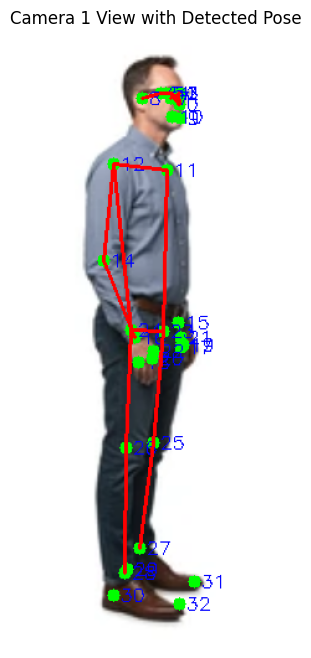

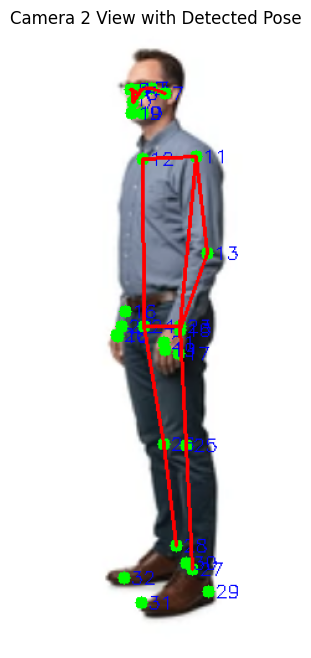

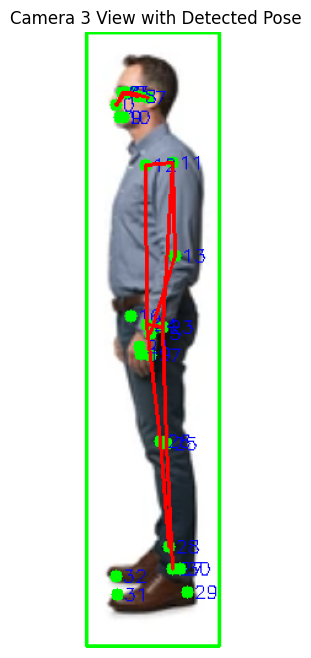

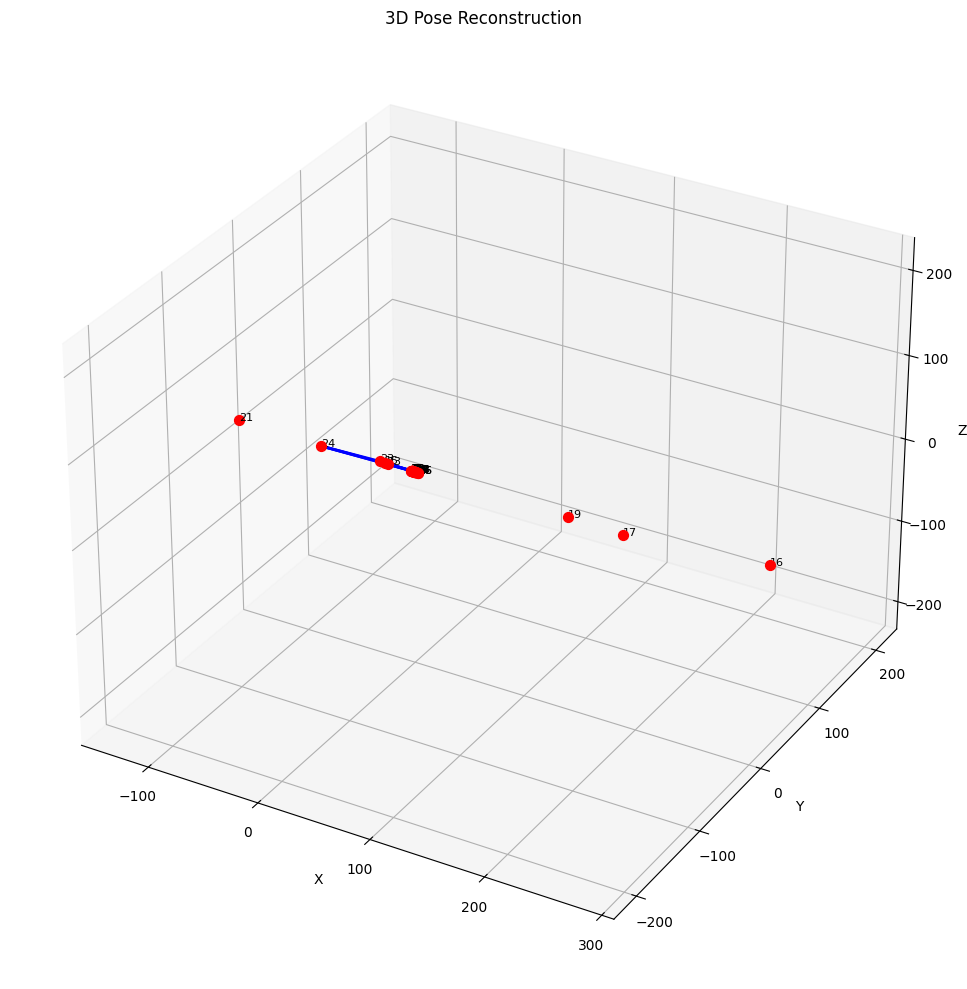

In [ ]:
# Install required packages
!pip install mediapipe opencv-python numpy matplotlib open3d deep-sort-realtime

import cv2
import numpy as np
import mediapipe as mp
import open3d as o3d
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ======================= 1. MEDIAPIPE POSE ESTIMATION =======================
class PoseEstimator:
    def __init__(self, min_detection_confidence=0.5):
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            min_detection_confidence=min_detection_confidence
        )
        self.mp_drawing = mp.solutions.drawing_utils

    def estimate_pose(self, image):
        """Estimate pose landmarks from an image"""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.pose.process(image_rgb)

        if not results.pose_landmarks:
            return None

        # Extract landmarks
        landmarks = {}
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            landmarks[idx] = {
                'x': landmark.x,
                'y': landmark.y,
                'z': landmark.z,
                'visibility': landmark.visibility
            }

        return landmarks

    def visualize_pose(self, image, landmarks):
        """Draw pose landmarks on an image"""
        if landmarks is None:
            return image

        img_copy = image.copy()
        h, w = img_copy.shape[:2]

        # Draw joints
        for idx, landmark_data in landmarks.items():
            if landmark_data['visibility'] > 0.3:
                x, y = int(landmark_data['x'] * w), int(landmark_data['y'] * h)
                cv2.circle(img_copy, (x, y), 5, (0, 255, 0), -1)
                cv2.putText(img_copy, str(idx), (x+5, y+5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Define connections for visualization
        connections = [
            # Torso
            (11, 12), (12, 24), (24, 23), (23, 11),
            # Arms
            (11, 13), (13, 15), (12, 14), (14, 16),
            # Legs
            (23, 25), (25, 27), (24, 26), (26, 28),
            # Face
            (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8)
        ]

        # Draw connections
        for connection in connections:
            if (connection[0] in landmarks and connection[1] in landmarks and
                landmarks[connection[0]]['visibility'] > 0.3 and
                landmarks[connection[1]]['visibility'] > 0.3):

                x1 = int(landmarks[connection[0]]['x'] * w)
                y1 = int(landmarks[connection[0]]['y'] * h)
                x2 = int(landmarks[connection[1]]['x'] * w)
                y2 = int(landmarks[connection[1]]['y'] * h)

                cv2.line(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

        return img_copy

# ======================= 2. DEEPSORT PLAYER TRACKING =======================
class PlayerTracker:
    def __init__(self, max_age=30):
        self.tracker = DeepSort(max_age=max_age, embedder='mobilenet', half=True)

    def track_player(self, image, landmarks):
        """Track player based on landmarks"""
        if landmarks is None:
            return None

        # Extract bounding box from landmarks
        h, w = image.shape[:2]
        x_coords = [lm['x'] for lm in landmarks.values()]
        y_coords = [lm['y'] for lm in landmarks.values()]

        # Add margin to bounding box
        margin = 0.1
        x_min = max(0, (min(x_coords) - margin) * w)
        y_min = max(0, (min(y_coords) - margin) * h)
        x_max = min(w, (max(x_coords) + margin) * w)
        y_max = min(h, (max(y_coords) + margin) * h)

        # Format for DeepSORT (left, top, width, height)
        bbox = [int(x_min), int(y_min), int(x_max-x_min), int(y_max-y_min)]
        detection = [bbox, 0.9, 0]  # bbox, confidence, class

        # Update tracker
        tracks = self.tracker.update_tracks([detection], frame=image)

        # Return track and bounding box if confirmed
        for track in tracks:
            if track.is_confirmed():
                track_bbox = track.to_ltrb()  # left, top, right, bottom
                return (track.track_id, track_bbox)

        return None

# ======================= 3. ENHANCED 3D RECONSTRUCTION =======================
class Pose3DReconstructor:
    def __init__(self, camera_positions, img_size=(640, 480)):
        self.camera_positions = camera_positions
        self.img_size = img_size
        self.projection_matrices = self._compute_projection_matrices()

    def _compute_projection_matrices(self):
        """Compute camera projection matrices from positions"""
        projection_matrices = []

        for position in self.camera_positions:
            # Camera intrinsic parameters - can be calibrated for real cameras
            fx, fy = 1000, 1000  # Focal length
            cx, cy = self.img_size[0]/2, self.img_size[1]/2  # Principal point

            # Create intrinsic matrix
            K = np.array([
                [fx, 0, cx],
                [0, fy, cy],
                [0, 0, 1]
            ])

            # Create rotation matrix (look at origin)
            pos = np.array(position)
            target = np.array([0, 0, 0])  # Look at origin
            up = np.array([0, 1, 0])      # Up direction

            # Compute camera axes
            z_axis = pos - target
            z_axis = z_axis / np.linalg.norm(z_axis)

            x_axis = np.cross(up, z_axis)
            x_axis = x_axis / np.linalg.norm(x_axis)

            y_axis = np.cross(z_axis, x_axis)

            # Create rotation matrix
            R = np.column_stack((x_axis, y_axis, z_axis))

            # Create translation vector
            t = -R @ pos

            # Full projection matrix
            P = K @ np.column_stack((R, t.reshape(3, 1)))
            projection_matrices.append(P)

        return projection_matrices

    def triangulate_point(self, points_2d):
        """Triangulate 3D point from 2D observations"""
        if len(points_2d) < 2:
            return None

        # Build linear system for DLT
        A = []
        for i, point in enumerate(points_2d):
            if point is None:
                continue

            x, y = point
            # Convert normalized to pixel coordinates
            x = x * self.img_size[0]
            y = y * self.img_size[1]

            P = self.projection_matrices[i]
            A.append(y * P[2, :] - P[1, :])
            A.append(P[0, :] - x * P[2, :])

        # Need at least 4 equations (2 points)
        if len(A) < 4:
            return None

        # Solve using SVD
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1, :]

        # Convert from homogeneous to Euclidean coordinates
        X = X / X[3]
        return X[:3]

    def reconstruct_pose(self, landmarks_list):
        """Reconstruct 3D pose from multiple 2D poses"""
        pose_3d = {}

        # For each landmark
        for joint_id in range(33):  # MediaPipe uses 33 landmarks
            points_2d = []

            # Collect 2D points from all cameras
            for camera_idx, landmarks in enumerate(landmarks_list):
                if landmarks is None or joint_id not in landmarks:
                    points_2d.append(None)
                    continue

                # Skip low visibility points
                if landmarks[joint_id]['visibility'] < 0.3:  # Lower threshold
                    points_2d.append(None)
                    continue

                points_2d.append((landmarks[joint_id]['x'], landmarks[joint_id]['y']))

            # Triangulate 3D point
            point_3d = self.triangulate_point(points_2d)
            if point_3d is not None:
                pose_3d[joint_id] = point_3d

        return pose_3d

    def visualize_3d_pose(self, pose_3d):
        """Visualize 3D pose using matplotlib"""
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Plot all landmarks
        for i, pos in pose_3d.items():
            ax.scatter(pos[0], pos[1], pos[2], c='red', s=50)
            ax.text(pos[0], pos[1], pos[2], str(i), fontsize=8)

        # Define skeleton connections
        connections = [
            # Torso
            (11, 12), (12, 24), (24, 23), (23, 11),
            # Arms
            (11, 13), (13, 15), (12, 14), (14, 16),
            # Legs
            (23, 25), (25, 27), (24, 26), (26, 28),
            # Face
            (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8)
        ]

        # Draw skeleton
        for connection in connections:
            if connection[0] in pose_3d and connection[1] in pose_3d:
                x = [pose_3d[connection[0]][0], pose_3d[connection[1]][0]]
                y = [pose_3d[connection[0]][1], pose_3d[connection[1]][1]]
                z = [pose_3d[connection[0]][2], pose_3d[connection[1]][2]]
                ax.plot(x, y, z, 'blue', linewidth=2)

        # Set equal aspect ratio
        max_range = np.array([
            max([pos[0] for pos in pose_3d.values()]) - min([pos[0] for pos in pose_3d.values()]),
            max([pos[1] for pos in pose_3d.values()]) - min([pos[1] for pos in pose_3d.values()]),
            max([pos[2] for pos in pose_3d.values()]) - min([pos[2] for pos in pose_3d.values()])
        ]).max() / 2.0

        mid_x = (max([pos[0] for pos in pose_3d.values()]) + min([pos[0] for pos in pose_3d.values()])) / 2
        mid_y = (max([pos[1] for pos in pose_3d.values()]) + min([pos[1] for pos in pose_3d.values()])) / 2
        mid_z = (max([pos[2] for pos in pose_3d.values()]) + min([pos[2] for pos in pose_3d.values()])) / 2

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        # Label axes
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Pose Reconstruction')

        plt.tight_layout()
        plt.show()

# ======================= MAIN PIPELINE =======================
def main(image_paths, camera_positions):
    """Run the complete 3D reconstruction pipeline"""
    # 1. Load images
    images = [cv2.imread(path) for path in image_paths]
    if any(img is None for img in images):
        raise ValueError("Failed to load one or more images")

    # 2. Initialize components
    pose_estimator = PoseEstimator()
    player_tracker = PlayerTracker()
    reconstructor = Pose3DReconstructor(camera_positions, (images[0].shape[1], images[0].shape[0]))

    # 3. Process each image
    landmarks_list = []
    visualized_images = []

    for i, image in enumerate(images):
        # Detect pose
        landmarks = pose_estimator.estimate_pose(image)
        landmarks_list.append(landmarks)

        # Visualize pose
        pose_image = pose_estimator.visualize_pose(image, landmarks)

        # Track player
        if landmarks:
            tracking_result = player_tracker.track_player(image, landmarks)
            if tracking_result:
                track_id, bbox = tracking_result
                cv2.rectangle(pose_image,
                             (int(bbox[0]), int(bbox[1])),
                             (int(bbox[2]), int(bbox[3])),
                             (0, 255, 0), 2)
                cv2.putText(pose_image, f"ID: {track_id}",
                           (int(bbox[0]), int(bbox[1])-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        visualized_images.append(pose_image)

        # Display 2D pose
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(pose_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Camera {i+1} View with Detected Pose")
        plt.axis('off')
        plt.show()

    # 4. Reconstruct 3D pose
    pose_3d = reconstructor.reconstruct_pose(landmarks_list)

    # 5. Visualize 3D reconstruction
    reconstructor.visualize_3d_pose(pose_3d)

    return pose_3d

# ======================= EXECUTION =======================
if __name__ == "__main__":
    # Image paths and camera positions
    image_paths = [
        "angle60.png",   # Camera 1
        "angle300.png",  # Camera 2
        "angle270.png"   # Camera 3
    ]

    camera_positions = [
        [-0.91, -0.414, 0],  # Camera 1
        [0.91, -0.414, 0],   # Camera 2
        [1, 0, 0]            # Camera 3
    ]

    # Run the pipeline
    pose_3d = main(image_paths, camera_positions)


In [ ]:
# Install required packages
!pip install mediapipe opencv-python numpy matplotlib open3d deep-sort-realtime

import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
from deep_sort_realtime.deepsort_tracker import DeepSort
from google.colab.patches import cv2_imshow

# ======================= MEDIAPIPE POSE ESTIMATION =======================
class PoseEstimator:
    def __init__(self, min_detection_confidence=0.5):
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            min_detection_confidence=min_detection_confidence
        )
        self.mp_drawing = mp.solutions.drawing_utils

    def estimate_pose(self, image):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.pose.process(image_rgb)

        if not results.pose_landmarks:
            return None

        landmarks = {}
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            landmarks[idx] = {
                'x': landmark.x,
                'y': landmark.y,
                'z': landmark.z,
                'visibility': landmark.visibility
            }

        return landmarks

    def draw_pose(self, image, landmarks):
        if landmarks is None:
            return image

        img_copy = image.copy()
        img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

        # Convert dictionary to MediaPipe format for visualization
        mp_landmarks = self.mp_pose.landmark_pb2.NormalizedLandmarkList()
        for idx, lm_data in sorted(landmarks.items()):
            landmark = mp_landmarks.landmark.add()
            landmark.x = lm_data['x']
            landmark.y = lm_data['y']
            landmark.z = lm_data['z']
            landmark.visibility = lm_data['visibility']

        self.mp_drawing.draw_landmarks(
            img_rgb,
            mp_landmarks,
            self.mp_pose.POSE_CONNECTIONS
        )

        return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# ======================= IMPROVED 3D RECONSTRUCTION =======================
class Pose3DReconstructor:
    def __init__(self, camera_positions):
        self.camera_positions = camera_positions
        self.cameras = self._setup_cameras()

    def _setup_cameras(self):
        cameras = []
        for position in self.camera_positions:
            # Camera intrinsics - more realistic focal length
            K = np.array([
                [1000, 0, 320],  # fx, 0, cx
                [0, 1000, 240],  # 0, fy, cy
                [0, 0, 1]
            ])

            # Create a better look-at rotation matrix
            pos = np.array(position)
            target = np.array([0, 0, 0])  # Look at origin

            # Calculate camera axes
            forward = target - pos
            forward = forward / np.linalg.norm(forward)

            right = np.cross(np.array([0, 1, 0]), forward)
            right = right / np.linalg.norm(right)

            up = np.cross(forward, right)

            # Create rotation matrix [R|t]
            R = np.column_stack((right, up, forward))
            t = -R @ pos

            # Create projection matrix P = K[R|t]
            P = K @ np.column_stack((R, t.reshape(3, 1)))

            cameras.append({
                'K': K,
                'R': R,
                't': pos,
                'P': P
            })

        return cameras

    def triangulate_point(self, points_2d, img_size=(640, 480)):
        """Triangulate with a lower visibility threshold and better error handling"""
        A = []

        for i, point in enumerate(points_2d):
            if point is None:
                continue

            # Convert normalized to pixel coordinates
            x, y = point[0] * img_size[0], point[1] * img_size[1]

            P = self.cameras[i]['P']
            A.append(y * P[2, :] - P[1, :])
            A.append(P[0, :] - x * P[2, :])

        # Need at least 4 equations (2 points visible in different cameras)
        if len(A) < 4:
            return None

        # Solve using SVD
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)

        # Get homogeneous point and convert to Euclidean
        point_3d = Vt[-1, :]
        point_3d = point_3d[:3] / point_3d[3]

        return point_3d

    def reconstruct_pose(self, landmarks_list, img_size=(640, 480)):
        """Reconstruct 3D pose with lower visibility threshold"""
        landmarks_3d = {}

        # Lower visibility threshold to include more landmarks
        visibility_threshold = 0.3  # Changed from 0.5

        for joint_id in range(33):  # MediaPipe has 33 landmarks
            points_2d = []

            for camera_idx, landmarks in enumerate(landmarks_list):
                if landmarks is None or joint_id not in landmarks:
                    points_2d.append(None)
                    continue

                # Use lower threshold
                if landmarks[joint_id]['visibility'] < visibility_threshold:
                    points_2d.append(None)
                    continue

                points_2d.append((landmarks[joint_id]['x'], landmarks[joint_id]['y']))

            # Triangulate 3D point
            point_3d = self.triangulate_point(points_2d, img_size)
            if point_3d is not None:
                landmarks_3d[joint_id] = point_3d

        return landmarks_3d

# ======================= COLAB-FRIENDLY VISUALIZATION =======================
def visualize_3d_skeleton(landmarks_3d):
    """Visualize 3D skeleton in Colab using Matplotlib"""
    if not landmarks_3d:
        print("No valid 3D landmarks to visualize")
        return

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot all landmarks
    for idx, pos in landmarks_3d.items():
        ax.scatter(pos[0], pos[1], pos[2], c='red', s=50)
        ax.text(pos[0], pos[1], pos[2], str(idx), fontsize=8)

    # Define connections
    connections = [
        # Torso
        (11, 12), (12, 24), (24, 23), (23, 11),
        # Arms
        (11, 13), (13, 15), (12, 14), (14, 16),
        # Legs
        (23, 25), (25, 27), (24, 26), (26, 28),
        # Face
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8)
    ]

    # Draw skeleton
    for connection in connections:
        if connection[0] in landmarks_3d and connection[1] in landmarks_3d:
            p1 = landmarks_3d[connection[0]]
            p2 = landmarks_3d[connection[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'blue', linewidth=2)

    # Set equal aspect ratio
    X = [pos[0] for pos in landmarks_3d.values()]
    Y = [pos[1] for pos in landmarks_3d.values()]
    Z = [pos[2] for pos in landmarks_3d.values()]

    max_range = max([
        max(X) - min(X),
        max(Y) - min(Y),
        max(Z) - min(Z)
    ]) * 0.5

    mid_x = (max(X) + min(X)) * 0.5
    mid_y = (max(Y) + min(Y)) * 0.5
    mid_z = (max(Z) + min(Z)) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Pose Reconstruction')

    # Try different view angles to get the best perspective
    ax.view_init(elev=20, azim=30)

    plt.tight_layout()
    plt.show()

# ======================= MAIN EXECUTION =======================
def main():
    # Image paths and camera positions
    image_paths = [
        "angle60.png",  # Camera 1
        "angle300.png",  # Camera 2
        "angle270.png"   # Camera 3
    ]

    camera_positions = [
        (-0.91, -0.414, 0),  # Camera 1
        (0.91, -0.414, 0),   # Camera 2
        (1, 0, 0)            # Camera 3
    ]

    # 1. Load images
    images = [cv2.imread(path) for path in image_paths]
    if any(img is None for img in images):
        print("Error: Failed to load one or more images")
        return

    # Get image dimensions
    img_height, img_width = images[0].shape[:2]

    # 2. Estimate poses
    pose_estimator = PoseEstimator()
    landmarks_list = []

    for i, image in enumerate(images):
        landmarks = pose_estimator.estimate_pose(image)
        landmarks_list.append(landmarks)

        # Visualize 2D pose
        if landmarks:
            pose_image = pose_estimator.draw_pose(image, landmarks)
            print(f"Camera {i+1} view:")
            cv2_imshow(pose_image)

    # 3. Reconstruct 3D pose
    reconstructor = Pose3DReconstructor(camera_positions)
    pose_3d = reconstructor.reconstruct_pose(
        landmarks_list,
        img_size=(img_width, img_height)
    )

    # 4. Visualize 3D skeleton
    visualize_3d_skeleton(pose_3d)

if __name__ == "__main__":
    main()


AttributeError: module 'mediapipe.python.solutions.pose' has no attribute 'landmark_pb2'